## Case 01: Variational Autoencoder (VAE)
* Dataset: CIFAR100
* DL Framework: Tensorflow-Keras
* DL Task: Image reconstruction

`PREREQUISITE` All modules (with their suitable versions) are installed properly.
<br>`TASK` Complete the notebook cell's code marked with <b>#TODO</b> comment.
<br>`OBJECTIVE` Achieve a min. validation accuracy of <b>90%</b> within <b>10 epochs</b>.
<br>`WARNING` Do <b>NOT</b> change any codes in the <i>config.ipynb</i> file.

### Import libraries

In [75]:
from ipynb.fs.full.config import init, load_cifar_100_data, accuracy, show_reconstructions
#TODO: please import other necessary libraries here
import keras
from tensorflow import shape as tf_shape
from tensorflow import random as tf_random
from tensorflow import exp as tf_exp
from keras.layers import Conv2D
import numpy as np
from numpy import random as np_random
from matplotlib import pyplot as plt

### Load the dataset

In [76]:
(X_train, _), (X_valid, _), (_, _) = load_cifar_100_data()
print(X_train.shape, X_valid.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


### Configure the hyperparameters

In [77]:
EPOCH = init()["EPOCH"] # DO NOT CHANGE THIS
SEED = init()["SEED"] # DO NOT CHANGE THIS
BATCH_SIZE = 64 #TODO: set hyperparameters (int)
CODINGS_SIZE = 4 #TODO: set parameters for the latent space representation (int)
LEARNING_RATE = 0.0005 #TODO: set hyperparameters (int)
IMG_SIZE = 32 #TODO: define the image size

In [78]:
K = keras.backend
tf_random.set_seed(SEED) # for reproduciable results
np_random.seed(SEED) # for reproduciable results

### Define the Model

In [79]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf_shape(log_var)) * K.exp(log_var / 2) + mean

In [80]:
def encoder(i, c, *args, **kwargs):
    """
    function name:
        encoder() = to compress the image inputs (latent)
    function parameters:
        i = image size
        c = coding size
    """
    inputs = keras.layers.Input(shape=[i, i, 3], name="encoder_input")
    #TODO: define the layers stack for the encoder part. you may use MLP, LSTM, or CNN.
    # variable 'z' will be the first layer
    z = keras.layers.Conv2D(
                            filters=8
                            , kernel_size=3
                            , activation="relu"
                            , padding="valid"
                            , name="encoder_conv_1")(inputs)
    # z = keras.layers.Conv2D(
    #                         filters=16
    #                         , kernel_size=3
    #                         , activation="relu"
    #                         , padding="valid"
    #                         , name="encoder_conv_2")(z)
    # z = keras.layers.Conv2D(
    #                         filters=32
    #                         , kernel_size=3
    #                         , activation="relu"
    #                         , padding="valid"
    #                         , name="encoder_conv_3")(z)
    # z = keras.layers.Flatten()(z)
    # z = keras.layers.Dense(units=16, activation="relu", name="encoder_dense_1")(z)

    codings_mean = keras.layers.Dense(c, name="encoder_mean")(z)
    codings_log_var = keras.layers.Dense(c, name="encoder_log_var")(z)
    codings = Sampling()([codings_mean, codings_log_var])

    return keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]), inputs, codings_mean, codings_log_var

In [81]:
def decoder(i, c, *args, **kwargs):
    """
    function name:
        decoder = to reconstruct the image (with the same size) from the compressed version (latent)
    function parameters:
        i = image size
        c = coding size
    """
    decoder_inputs = keras.layers.Input(shape=[30, 30, c], name="decoder_input")
    #TODO: define the layers stack for the decoder part. you may use MLP, LSTM, or CNN.
    # variable 'x' will be the first layer
    # x = keras.layers.Dense(units=16, activation="relu", name="decoder_dense_1")(decoder_inputs)
    x = keras.layers.Conv2DTranspose(filters=8, kernel_size=3, padding="same", name="decoder_conv2d_transpose_1")(decoder_inputs)
    # x = keras.layers.Dense(units=(30 * 30 * 8), activation="relu", name="decoder_dense_2")(x)
    # x = keras.layers.Reshape(target_shape=(30, 30, 8))(x)
    # x = keras.layers.Conv2DTranspose(
    #                         filters=16
    #                         , kernel_size=3
    #                         , activation="relu"
    #                         , padding="valid"
    #                         , name="decoder_conv2d_transpose_1")(x)
    #
    # x = keras.layers.Conv2DTranspose(
    #                     filters=8
    #                     , kernel_size=3
    #                     , activation="relu"
    #                     , padding="valid"
    #                     , name="decoder_conv2d_transpose_2")(x)

    x = keras.layers.Conv2DTranspose(
                            filters=3
                            , kernel_size=3
                            , activation="relu"
                            , padding="valid"
                            , name="decoder_conv2d_transpose_3")(x)
    outputs = x
    return keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [82]:
variational_encoder, inputs, codings_mean, codings_log_var = encoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_encoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 30, 30, 8)    224         ['encoder_input[0][0]']          
                                                                                                  
 encoder_mean (Dense)           (None, 30, 30, 4)    36          ['encoder_conv_1[0][0]']         
                                                                                                  
 encoder_log_var (Dense)        (None, 30, 30, 4)    36          ['encoder_conv_1[0][0]']         
                                                                                           

In [83]:
variational_decoder = decoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_decoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 30, 30, 4)]       0         
                                                                 
 decoder_conv2d_transpose_1   (None, 30, 30, 8)        296       
 (Conv2DTranspose)                                               
                                                                 
 decoder_conv2d_transpose_3   (None, 32, 32, 3)        219       
 (Conv2DTranspose)                                               
                                                                 
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


In [84]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / (np.prod(IMG_SIZE)))

### Compile the model

In [85]:
#TODO: define your loss function, optimizer, and metric
...
variational_ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    , loss=keras.losses.MeanAbsoluteError()
    , metrics=[accuracy]
)

### Train the model
* <b>Bechmark:</b> Validation accuracy fell at `91.48%` within 10 epochs.
* If you encounter this `WARNING:tensorflow:AutoGraph ...` in the first epoch, please ignore.

In [86]:
history = variational_ae.fit(X_train, X_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, X_valid))

Epoch 1/10
704/704 [==============================] - 28s 39ms/step - loss: 0.1805 - accuracy: 0.7957 - val_loss: 0.1103 - val_accuracy: 0.8799
Epoch 2/10
704/704 [==============================] - 27s 39ms/step - loss: 0.1031 - accuracy: 0.8913 - val_loss: 0.0981 - val_accuracy: 0.9006
Epoch 3/10
704/704 [==============================] - 27s 39ms/step - loss: 0.0961 - accuracy: 0.9053 - val_loss: 0.0948 - val_accuracy: 0.9088
Epoch 4/10
704/704 [==============================] - 28s 39ms/step - loss: 0.0942 - accuracy: 0.9102 - val_loss: 0.0938 - val_accuracy: 0.9117
Epoch 5/10
704/704 [==============================] - 28s 40ms/step - loss: 0.0936 - accuracy: 0.9122 - val_loss: 0.0934 - val_accuracy: 0.9126
Epoch 6/10
704/704 [==============================] - 31s 44ms/step - loss: 0.0933 - accuracy: 0.9130 - val_loss: 0.0932 - val_accuracy: 0.9133
Epoch 7/10
704/704 [==============================] - 32s 45ms/step - loss: 0.0931 - accuracy: 0.9136 - val_loss: 0.0932 - val_accuracy:

### Visualize training and validation results

Example output:

![VAE_acc_loss](img/vae_plot.png)

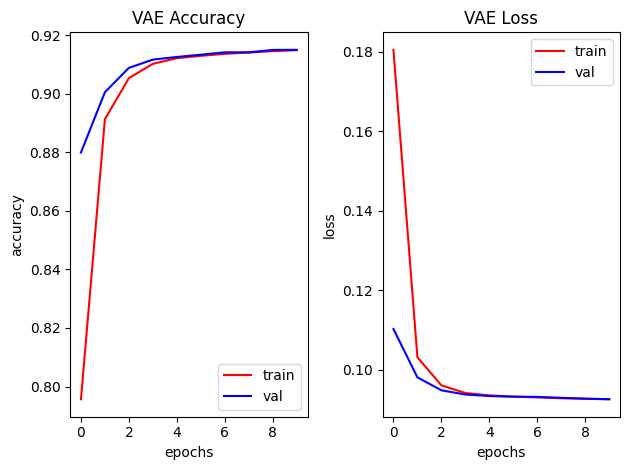

In [87]:
#TODO: plot the loss and accuracy results from both training and validation, as depicted in the image above

from matplotlib import pyplot as plt

history_dict = history.history

train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(0, len(train_loss))

fig, ax = plt.subplots(1,2)

ax[0].plot(epochs, train_accuracy, color="r", label="train")
ax[0].plot(epochs, val_accuracy, color="b", label="val")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].set_title("VAE Accuracy")
ax[0].legend()

ax[1].plot(epochs,train_loss, color="r", label="train")
ax[1].plot(epochs, val_loss, color="b", label="val")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("VAE Loss")
ax[1].legend()

plt.tight_layout()
plt.show()




### Test the model

1/1 [==============================] - 0s 196ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


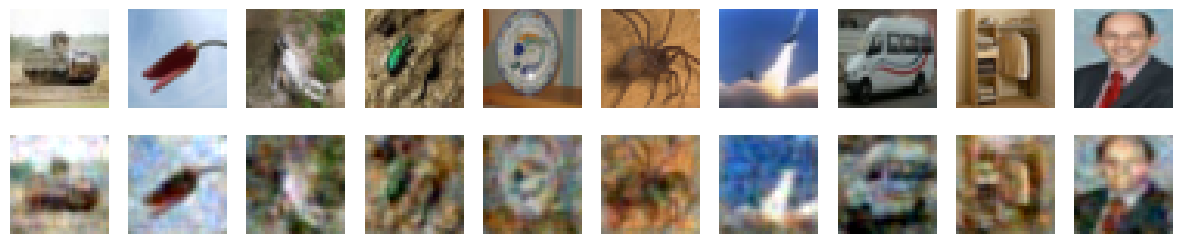

In [88]:
show_reconstructions(variational_ae, X_valid)

### Copyright 2022 PT. Agriaku Digital Indonesia
* You may NOT use this file except there is written permission from AgriAku.
* Any questions can be address to `nicholas.dominic@agriaku.com`.